Using device: cuda


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Device set to use cuda:0
Processing questions for llama 3.1 8B-instruct: 100%|██████████| 313/313 [4:54:58<00:00, 56.55s/it]


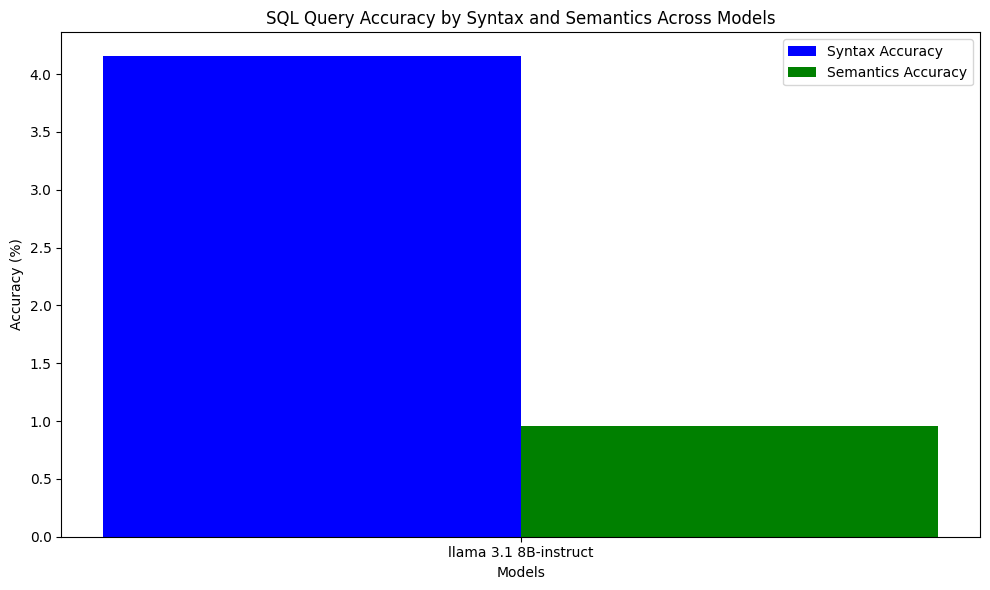

Model Accuracy Scores: {'llama 3.1 8B-instruct': {'syntax': 4.15335463258786, 'semantics': 0.9584664536741214}}


In [1]:
import sqlite3
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import re
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

class ModelLoader:
    def __init__(self, model_name, model_path):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {device}")  # Check if running on GPU or CPU
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForCausalLM.from_pretrained(model_path).to(device)
        self.pipeline = pipeline(
            "text-generation",
            model=self.model,
            tokenizer=self.tokenizer,
            device=0 if device == "cuda" else -1,
            truncation=True,
            pad_token_id=self.tokenizer.eos_token_id,
            temperature=0.5,
            top_p=0.7,
            max_length=2048,
            return_full_text=False
        )

class SQLPromptBuilder:
    def __init__(self, base_prompt):
        self.base_prompt = base_prompt

    def build_prompt(self, question, schema):
        return (
            f"{self.base_prompt}\n\n"
            f"The nba_roster table contains the following columns: {schema}. And \"--\" is used as nil in the table."
            f"Given a question, return the SQL query and thought process in a structured JSON format.\n\n"
            f"Return ONLY a valid JSON object in the following format with NO additional text:\n\n"
            f"{{\n"
            f"  \"question\": \"<The given question>\",\n"
            f"  \"thought\": \"<Your thought process>\",\n"
            f"  \"sql\": \"<SQL query>\"\n"
            f"}}\n\n"
            f"Now, answer the following question:\n"
            f"Question: {question}"
        )

class SQLQueryGenerator:
    def __init__(self, model_loader, prompt_builder):
        self.model_loader = model_loader
        self.prompt_builder = prompt_builder

    def generate_response(self, question, schema):
        prompt = self.prompt_builder.build_prompt(question, schema)
        response = self.model_loader.pipeline(prompt, num_return_sequences=1)
        raw_output = response[0]["generated_text"]
        return self.extract_json(raw_output)

    @staticmethod
    def extract_json(output):
        try:
            start = output.index("{")
            end = output.rindex("}") + 1
            return json.loads(output[start:end])
        except (ValueError, json.JSONDecodeError):
            return {"error": "Failed to extract valid JSON"}

class SQLValidator:
    @staticmethod
    def validate_sql(sql):
        # Regex for validating SELECT queries
        pattern = r"^\s*SELECT .*;\s*$"
        return bool(re.match(pattern, sql, re.IGNORECASE))

class SQLExecutor:
    def __init__(self, database_path):
        self.database_path = database_path

    def execute(self, sql):
        try:
            conn = sqlite3.connect(self.database_path)
            cursor = conn.cursor()
            cursor.execute(sql)
            result = cursor.fetchall()
            conn.close()
            return result
        except sqlite3.Error as e:
            return f"Error: {e}"

class SQLQueryPipeline:
    def __init__(self, database_path, base_prompt, questions_file):
        self.database_path = database_path
        self.models = {}
        self.prompt_builder = SQLPromptBuilder(base_prompt)
        self.questions_file = questions_file
        self.sql_executor = SQLExecutor(database_path)

    def add_model(self, model_name, model_path):
        self.models[model_name] = ModelLoader(model_name, model_path)

    def load_questions(self):
        with open(self.questions_file, "r") as f:
            return [json.loads(line) for line in f]

    def run_pipeline(self):
        questions = self.load_questions()
        accuracy_scores = {model_name: {'syntax': 0, 'semantics': 0} for model_name in self.models}
        total_questions = len(questions)
        results = {model_name: [] for model_name in self.models}

        for model_name, model_loader in self.models.items():
            generator = SQLQueryGenerator(model_loader, self.prompt_builder)
            for question_data in tqdm(questions, desc=f"Processing questions for {model_name}"):
                question = question_data["question"]
                ground_truth_sql = question_data["sql"]

                # Get the expected result
                expected_result = self.sql_executor.execute(ground_truth_sql)

                # Generate the SQL query
                response = generator.generate_response(question, schema)
                sql_query = response.get("sql", "")
                generated_result = None

                # Check for syntax correctness
                syntax_correct = SQLValidator.validate_sql(sql_query)

                if syntax_correct:
                    generated_result = self.sql_executor.execute(sql_query)

                # Compare for semantics correctness
                semantics_correct = self.compare_results(expected_result, generated_result) if syntax_correct else False

                # Update accuracy scores
                accuracy_scores[model_name]['syntax'] += int(syntax_correct)
                accuracy_scores[model_name]['semantics'] += int(semantics_correct)

                results[model_name].append({
                    "question": question,
                    "generated_sql": sql_query,
                    "expected_sql": ground_truth_sql,
                    "generated_result": generated_result,
                    "expected_result": expected_result,
                    "syntax_correct": syntax_correct,
                    "semantics_correct": semantics_correct
                })

        # Calculate accuracy percentages
        accuracy_scores = {
            model: {
                'syntax': (score['syntax'] / total_questions) * 100,
                'semantics': (score['semantics'] / total_questions) * 100
            }
            for model, score in accuracy_scores.items()
        }

        # Save results to JSON files
        for model_name, result_data in results.items():
            with open(f"/content/{model_name}_results.json", "w") as f:
                json.dump(result_data, f, indent=4)

        # Plot accuracy results
        self.plot_accuracy(accuracy_scores)
        return accuracy_scores

    def compare_results(self, expected_result, generated_result):
        return expected_result == generated_result

    def plot_accuracy(self, accuracy_scores):
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plotting the syntax and semantics accuracy
        models = list(accuracy_scores.keys())
        syntax_accuracies = [score['syntax'] for score in accuracy_scores.values()]
        semantics_accuracies = [score['semantics'] for score in accuracy_scores.values()]

        bar_width = 0.35
        index = range(len(models))

        ax.bar(index, syntax_accuracies, bar_width, label='Syntax Accuracy', color='blue')
        ax.bar([i + bar_width for i in index], semantics_accuracies, bar_width, label='Semantics Accuracy', color='green')

        ax.set_xlabel('Models')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title('SQL Query Accuracy by Syntax and Semantics Across Models')
        ax.set_xticks([i + bar_width / 2 for i in index])
        ax.set_xticklabels(models)
        ax.legend()

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    database_path = "/content/nba_roster.db"
    schema = "Team, NAME, Jersey, POS, AGE, HT, WT, COLLEGE, SALARY"
    base_prompt = "You are a data analyst."
    questions_file = "/content/generated_queries_large_filtered.jsonl"

    pipeline_obj = SQLQueryPipeline(database_path, base_prompt, questions_file)
    pipeline_obj.add_model("llama 3.1 8B-instruct", "meta-llama/Llama-3.1-8B-instruct")
    #pipeline_obj.add_model("llama 3.2 3B-instruct", "meta-llama/Llama-3.2-3B-instruct")

    accuracy_scores = pipeline_obj.run_pipeline()
    print("Model Accuracy Scores:", accuracy_scores)
